# Оценка результатов A/B-теста

## Описание проекта

### Цель и задачи
Необходимо провести оценку результатов A/B-теста:

1. Оценить корректность проведения теста:

   1. Проверить пересечение тестовой аудитории с конкурирующим тестом;
   2. Проверить совпадение времени проведения теста и маркетинговых событий;
   3. Проверить равномерность распределения пользователей по тестовым группам и принадлежность пользователей к обеим группам.


2. Проанализировать результаты теста:

   1. Проверить, достигнуты ли ожидаемые эффекты (метрики улучшились на ожидаемый процент);
   2. Если ожидаемые эффекты достигнуты, то проверить статистическую значимость изменений (сформулировать гипотезы, выбрать статистический критерий и уровень статистической значимости, применить выбранный статистический критерий и оценить результаты).


### Техническое задание

- Название теста: `recommender_system_test`;
- Группы: А — контрольная, B — новая платёжная воронка;
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000;
- Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  - Конверсия в просмотры карточек товаров — событие `product_page`,
  - Конверсия в просмотры корзины — `product_cart`,
  - Конверсия в покупки — `purchase`.

## Данные

1. Файл `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год:

   - `name` — название маркетингового события;
   - `regions` — регионы, в которых будет проводиться рекламная кампания;
   - `start_dt` — дата начала кампании;
   - `finish_dt` — дата завершения кампании.


2. Файл `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года:

   - `user_id` — идентификатор пользователя;
   - `first_date` — дата регистрации;
   - `region` — регион пользователя;
   - `device` — устройство, с которого происходила регистрация.


3. Файл `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

   - `user_id` — идентификатор пользователя;
   - `event_dt` — дата и время покупки;
   - `event_name` — тип события;
   - `details` — дополнительные данные о событии. Например, для покупок (`purchase`) в этом поле хранится стоимость покупки в долларах.


4. `final_ab_participants.csv` — таблица участников тестов:

   - `user_id` — идентификатор пользователя;
   - `ab_test` — название теста;
   - `group` — группа пользователя.

## <a id='content'>План проекта</a>

1. [Подготовка и настройка](#step-0)
2. [Загрузка и изучение данных](#step-1)
3. [Предобработка данных](#step-2)
4. [Оценка корректности проведения A/B-теста](#step-3)
5. [Исследовательский анализ данных](#step-4)
6. [Оценка результатов A/B-тестирования](#step-5)
7. [Общие выводы](#result)

---

## <a id='step-0'>Шаг 0. Подготовка и настройка¶</a>

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import math as mth
from datetime import datetime

from scipy import stats as st
from termcolor import colored # раскраска текста

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
# настройки графиков
large = 16; medium = 14; small = 12

params = {'axes.titlesize': large,
          'axes.labelsize': medium,
          'legend.fontsize': medium,
          'figure.titlesize': large,
          'figure.figsize': (10, 6),
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'axes.grid': True,
          'legend.loc': 'upper left',
          'axes.titlepad': 20.0, # отступ названия графика
          'axes.labelpad': 8.0, # отступ для подписей осей
          'legend.title_fontsize': medium,
         }
plt.rcParams.update(params)
# plt.rcParams.keys() # список параметров и их значения

plt.style.use('seaborn-muted') # единый стиль графиков
sns.set_style('white')

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-1'>Шаг 1. Загрузка и изучение данных</a>

### 1.1. Автоматизация

Так как датасетов у нас несколько, напишем **функцию `about_df`**, которая будет:
- Принимать на вход имя файла;
- Выводить примеры строк, информацию о датасете и числовое описание данных, количество и долю пропусков по каждому столбцу, количество дубликатов и сами дублирующиеся строки;
- Возвращать прочитанный из файла датафрейм, чтобы его можно было сохранить в переменную.

In [4]:
def about_df(df_name):   
    data = pd.read_csv('/datasets/{}.csv'.format(df_name))
    
    print(colored('Примеры строк:', attrs=['bold']))
    if len(data)>=5:
        display(data.sample(5))
    else:
        display(data)
    
    print(colored('\nИнформация о датасете:', attrs=['bold']))
    display(data.info())
    
    print(colored('\nЧисловое описание данных:', attrs=['bold']))
    display(data.describe())

    print(colored('\nПропуски (количество и доля):', attrs=['bold']))
    display(data.isna().agg(['sum', 'mean']))
    
    # дубликаты
    duplicates = data[data.duplicated()]
    duplicates_cnt = len(duplicates)
    print(colored('\nКоличество дубликатов:', attrs=['bold']), duplicates_cnt)
    if duplicates_cnt > 0:
        display(duplicates_cnt)
    
    return data

### 1.2. Календарь маркетинговых событий на 2020 год

Воспользуемся написанной нами функцией:

In [5]:
mark_events = about_df('ab_project_marketing_events')

Примеры строк:


,name,regions,start_dt,finish_dt
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


None


Числовое описание данных:


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Single's Day Gift Promo,APAC,2020-03-08,2020-03-19
freq,1,4,1,1



Пропуски (количество и доля):


,name,regions,start_dt,finish_dt
sum,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0



Количество дубликатов: 0


Пропусков и дубликатов нет, но потребуется преобразовать значения `start_dt` и `finish_dt` в даты.

### 1.3. Данные о пользователях, зарегистрировавшихся с 7 по 21 декабря 2020 года

In [6]:
users = about_df('final_ab_new_users')

Примеры строк:


,user_id,first_date,region,device
53753,F6610DC19E913355,2020-12-13,APAC,iPhone
38819,3044AD6360167980,2020-12-17,EU,iPhone
41255,F466E95593D447F8,2020-12-11,EU,Android
51934,EDC86B77C42EF17C,2020-12-19,EU,iPhone
59198,A21EFAA06070F630,2020-12-20,APAC,Android



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


None


Числовое описание данных:


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,B279667F69E9D4E5,2020-12-21,EU,Android
freq,1,6290,46270,27520



Пропуски (количество и доля):


,user_id,first_date,region,device
sum,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0



Количество дубликатов: 0


Дополнительно посмотрим на регионы:

In [7]:
# регионы пользователей
users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

Пропусков и дубликатов нет, но нужно преобразовать значения столбца `first_date` в даты.

Так же стоит отметить, что нам понадобятся данные только по пользователям из региона EU.

### 1.4. Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

In [8]:
events = about_df('final_ab_events')

Примеры строк:


,user_id,event_dt,event_name,details
178387,A43E4DB61B2DD333,2020-12-17 07:08:54,product_page,NaN
153053,A8840CCBACBF90D8,2020-12-13 04:17:34,product_page,NaN
360309,7B36B9F6F4C05178,2020-12-20 04:05:17,login,NaN
203511,4818B54E07673DE8,2020-12-21 11:11:19,product_page,NaN
114008,259F821656042A11,2020-12-24 20:21:45,product_cart,NaN



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None


Числовое описание данных:


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000



Пропуски (количество и доля):


,user_id,event_dt,event_name,details
sum,0.0,0.0,0.0,377577.000000
mean,0.0,0.0,0.0,0.857512



Количество дубликатов: 0


Посмотрим, по событиям каких типов есть информация в поле `details`:

In [9]:
events.loc[~events['details'].isna(), 'event_name'].value_counts()

purchase    62740
Name: event_name, dtype: int64

Детали есть только по покупкам. Посмотрим, по всем ли покупкам есть детали:

In [10]:
events.loc[events['event_name'] == 'purchase', 'details'].isna().sum()

0

Итого, дубликатов нет, а пропуски в `details` объясняются тем, что детали есть по событиям только одного типа (`purchase`). При этом по каждой покупке есть детали.

В этом датасете нужно:
- Преобразовать значения столбца `event_dt` в дату и время;
- Добавить столбец с датой без времени.

### 1.5. Таблица участников тестов

In [11]:
tests = about_df('final_ab_participants')

Примеры строк:


,user_id,group,ab_test
14107,32570DEBD1999D3A,A,interface_eu_test
5963,70A42D781A4E0CF4,B,recommender_system_test
16684,ED114A9E9373208C,B,interface_eu_test
10369,E1F5559721CC6E4D,A,interface_eu_test
7485,F8151E51EA08F337,A,interface_eu_test



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


None


Числовое описание данных:


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,E253DCB9EC1C014E,A,interface_eu_test
freq,2,9655,11567



Пропуски (количество и доля):


,user_id,group,ab_test
sum,0.0,0.0,0.0
mean,0.0,0.0,0.0



Количество дубликатов: 0


Видим:
- Пропусков нет;
- Судя по общему количеству и количеству уникальных значений в поле `user_id`, у нас есть пользователи, которые попали либо в несколько тестов, либо в несколько групп в одном тесте, либо и то, и другое. Выясним это на этапе оценки корректности проведения теста.

### Промежуточные выводы

По итогам ознакомления данных обозначили фронт работы по предобработке данных:

- Датасет `mark_events`: преобразовать значения `start_dt` и `finish_dt` в даты.


- `users` — `first_date` в даты;


- `events`:
  - `event_dt` в дату и время;
  - Добавить столбец с датой без времени.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-2'>Шаг 2. Предобработка данных</a>

1. Преобразуем даты в столбцах датасетов:

In [12]:
# список датасетов, в которых есть столбцы с датами
list_of_dfs = (mark_events, users, events)

for df in list_of_dfs:
    for col in df.columns:
        if 'dt' in col or 'date' in col:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            print(f'Тип данных в столбцe {col}: {df[col].dtypes}')

Тип данных в столбцe start_dt: datetime64[ns]
Тип данных в столбцe finish_dt: datetime64[ns]
Тип данных в столбцe first_date: datetime64[ns]
Тип данных в столбцe event_dt: datetime64[ns]


2. В датафрейме `events` выделим только дату события в отдельный столбец:

In [13]:
events['event_date'] = pd.to_datetime(events['event_dt'].dt.date)
events.sample(5)

,user_id,event_dt,event_name,details,event_date
199455,774A367EB8578253,2020-12-20 19:53:08,product_page,NaN,2020-12-20
230531,950D8D7721EA55D3,2020-12-24 16:22:17,product_page,NaN,2020-12-24
144539,DD1B5BFEFC7F8285,2020-12-12 17:22:53,product_page,NaN,2020-12-12
76195,9BC31D71886CC19C,2020-12-13 07:55:14,product_cart,NaN,2020-12-13
232561,83D1B1A0DBE80B4B,2020-12-25 05:26:04,product_page,NaN,2020-12-25


In [14]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
event_date    440317 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 16.8+ MB


### Промежуточные выводы

На этом этапе мы преобразовали типы данных в столбцах с датами и выделили только дату без времени в датафрейме `events`.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-3'>Шаг 3. Оценка корректности проведения A/B-теста</a>

1. Зафиксируем в переменных условия теста:

In [15]:
# название теста
test_name = 'recommender_system_test'

# дата запуска теста
test_start = datetime(2020,12,7).strftime('%Y-%m-%d')

# дата остановки набора новых пользователей
new_users_end = datetime(2020,12,21).strftime('%Y-%m-%d')

# дата остановки
test_end = datetime(2021,1,4).strftime('%Y-%m-%d')

# регион (для переиспользования можно задать в виде списка,
# если в будущих тестах могут участвовать пользователи из нескольких регионов)
region = 'EU'

# процент новых пользователей из целевого региона
au_pcnt = 15

# ожидаемое количество участников теста
users_cnt_expected = 6000

# конверсионное окно в днях
conversion_window = 14

# конверсионные метрики
conversion_metrics = {'product_page':'просмотр карточек товаров',
                      'product_cart':'просмотр корзины',
                      'purchase':'покупки'}

2. Отберем новых пользователей из региона EU, которые зарегистрировались в период с `test_start` по `new_users_end`:

In [16]:
users_eu = users[(users['region'] == region) \
                 & (users['first_date'] >= test_start) & (users['first_date'] <= new_users_end)]
total_users_eu = users_eu.shape[0]
print(f'Всего за период с {test_start} по {new_users_end} пришло {total_users_eu} новых пользователей из региона {region}.')

Всего за период с 2020-12-07 по 2020-12-21 пришло 42340 новых пользователей из региона EU.


3. Присоединим к списку новых пользователей из предыдущего пункта данные по участникам тестов (пересечение по `user_id`):

In [17]:
tests_eu = users_eu.merge(tests, on=['user_id'], how='inner')

print(f'Количество новых пользователей из {region}, попавших хотя бы в один A/B-тест: {len(tests_eu)}')

Количество новых пользователей из EU, попавших хотя бы в один A/B-тест: 16916


In [18]:
tests_eu.sample(5)

,user_id,first_date,region,device,group,ab_test
3267,CB5F0081A83B7397,2020-12-14,EU,Android,A,recommender_system_test
12807,1C53DDC5501E6F0E,2020-12-12,EU,Android,B,interface_eu_test
4656,C72752E18AD12854,2020-12-21,EU,iPhone,A,interface_eu_test
121,1632E8454F655D06,2020-12-07,EU,Mac,B,recommender_system_test
10642,392813BD834ECD63,2020-12-11,EU,Android,A,recommender_system_test


4. Проверим, есть ли пользователи, которые попали сразу в обе группы нашего теста:

In [19]:
users_in_ab = (tests_eu.query('ab_test == @test_name')
               .groupby(['user_id', 'ab_test']).agg({'group':'nunique'})
               .sort_values(by='group', ascending=False))

print('Количество пользователей, попавших в обе группы теста {}: {}'.format(test_name, len(users_in_ab.query('group > 1'))))

Количество пользователей, попавших в обе группы теста recommender_system_test: 0


5. Отберем ID пользователей, которые участвовали в нашем тесте:

In [20]:
test_users_ids = list(tests_eu.query('ab_test == @test_name')['user_id'])
display(test_users_ids[:5])
print('Количество пользователей, участвовавших в тесте {}: {}'.format(test_name, len(test_users_ids)))

['D72A72121175D8BE',
 'E6DE857AFBDC6102',
 'DD4352CDCF8C3D57',
 '831887FE7F2D6CBA',
 '4CB179C7F847320B']

Количество пользователей, участвовавших в тесте recommender_system_test: 6351


6. Проверим, пересекается ли аудитория нашего теста с другими тестами:

In [21]:
users_in_manytests = (tests_eu.query('user_id in @test_users_ids')
                      .groupby(['user_id'], as_index=False).agg({'ab_test':'nunique'})
                      .query('ab_test > 1'))
users_in_manytests.sample(5)

,user_id,ab_test
4805,C0DDE3AA2A89024F,2
4357,AEE24B6142A3C431,2
1819,4B5225B3DCB853CE,2
2340,5F8134ACF9295C80,2
2811,739656E0D7B50B30,2


Видим, что аудитория нашего теста пересекается с другими тестами. Оценим масштаб бедствия:

In [22]:
# записываем id пользователей, попавших в несколько тестов
users_in_manytests_ids = list(users_in_manytests['user_id'])

users_in_manytests_cnt = len(users_in_manytests_ids)

print('Количество пользователей, попавших в несколько тестов: {:.0f} ({:.1%})'
      .format(users_in_manytests_cnt, users_in_manytests_cnt/len(test_users_ids)))

Количество пользователей, попавших в несколько тестов: 1602 (25.2%)


Видим, что четверть аудитории нашего теста попали и в другой / другие тесты тоже.

Кажется, что **было бы правильно не использовать данные по пользователям, попавшим в несколько тестов**. Но с другой стороны, я думаю, что в реальных продуктах одновременно может идти много тестов, и пересечение неизбежно.

Думаю, что **можно оставить этих пользователей, если в каждой группе нашего теста примерно одинаковая доля участников из разных групп в других тестах**. Например, если в группе A нашего теста 100 человек из группы B другого теста (и это составляет 5% от общего числа пользователей в группе А нашего теста), то среди участников группы B нашего теста должно быть тоже примерно 5% пользователей, попавших в группу B другого теста.

Проверим это:

In [23]:
# запишем общее количество участников по группам нашего теста
in_other_tests = (tests_eu.query('ab_test == @test_name')
                  .groupby(['group'], as_index=False).agg({'user_id':'nunique'})
                  .rename(columns={'user_id':'users_cnt'}))
display(in_other_tests)

# проверим, совпадает ли сумма по группам
print(in_other_tests['users_cnt'].sum())

,group,users_cnt
0,A,3634
1,B,2717


6351


In [24]:
# id пользователей в группе A нашего теста
users_a = list(tests_eu.query('ab_test == @test_name & group=="A"')['user_id'].unique())
len(users_a)

3634

In [25]:
# id пользователей в группе B нашего теста
users_b = list(tests_eu.query('ab_test == @test_name & group=="B"')['user_id'].unique())
len(users_b)

2717

In [26]:
# перебираем все другие тесты (если их будет больше двух)
for test in tests_eu['ab_test'].unique():
    
    # исключаем целевой тест, с которым мы работаем    
    if test != test_name:
        work_df = tests_eu[tests_eu['ab_test'] == test]
        
        # перебираем группы другого теста
        for group in work_df['group'].unique():
            # записываем id пользователей, попавших в каждую группу другого теста
            users_in_group = list(work_df.loc[work_df['group'] == group, 'user_id'].unique())
        
            # считаем количество пересечений по id пользователей в группах нашего теста и группе другого теста
            intersection_a_cnt = len(set(users_in_group).intersection(users_a))
            intersection_b_cnt = len(set(users_in_group).intersection(users_b))
        
            # собираем датафрейм
            cnt_name = test + '_' + group
            intersection_cnt = pd.DataFrame({'group':['A', 'B'], cnt_name:[intersection_a_cnt, intersection_b_cnt]})
        
            # присоединяем полученный датафрейм к датафрейму с количеством участников по группам нашего теста
            in_other_tests = in_other_tests.merge(intersection_cnt, on='group', how='left')
        
            # имя колонки с процентами
            pcnt_name = cnt_name + '_pcnt'
            in_other_tests[pcnt_name] = round(in_other_tests[cnt_name] / in_other_tests['users_cnt'] * 100, 2)
        
in_other_tests

,group,users_cnt,interface_eu_test_A,interface_eu_test_A_pcnt,interface_eu_test_B,interface_eu_test_B_pcnt
0,A,3634,482,13.26,439,12.08
1,B,2717,337,12.40,344,12.66


Видим, что доли пользователей, которые попали в экспериментальную группу B и контрольную группу А другого теста (`interface_eu_test`), примерно одинаковые в наших группах. Поэтому считаю, что можно оставить этих пользователей (если изменения, тестируемые в другом тесте, повлияли на поведение наших пользователей, то эффект должен быть примерно одинаковым в обеих группах).

7. Проверим равномерность распределения пользователей по группам нашего теста:

In [27]:
round(abs(min(in_other_tests['users_cnt']) / max(in_other_tests['users_cnt']) - 1) * 100, 1)

25.2

Относительное различие в количестве пользователей в группах очень большое – 25%. Это говорит о том, что траффик распределялся неравномерно.

8. Проверим, какая доля от всех новых пользователей из EU за период с `test_start` по `new_users_end`, попала в наш тест (по ТЗ должно быть около 15%):

In [28]:
round(len(test_users_ids) / total_users_eu * 100, 1)

15.0

Тут идеальное попадание в ТЗ.

9. И еще посмотрим, проходили ли какие-то маркетинговые активности в регионе EU во время нашего теста:

In [29]:
mark_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Отбираем по региону:

In [30]:
mark_events['in_eu'] = mark_events['regions'].apply(lambda x: 'EU' in x.split(', '))
mark_events_eu = mark_events.query('in_eu == True')
mark_events_eu

,name,regions,start_dt,finish_dt,in_eu
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,True
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,True
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,True
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,True
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,True
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,True


Отбираем по датам:

In [31]:
print(test_start)
print(test_end)

2020-12-07
2021-01-04


In [32]:
mark_events_eu_time = mark_events_eu.query('finish_dt >= @test_start & finish_dt <= @test_end')

if len(mark_events_eu_time) == 0:
    print('Во время теста нет маркетинговых событий.')
else:
    display(mark_events_eu_time)

,name,regions,start_dt,finish_dt,in_eu
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True


### Промежуточные выводы

На этом этапе мы проверили корректность проведения теста и отобрали пользователей, данные по которым будем анализировать дальше.

- Всего за период с 2020-12-07 по 2020-12-21 пришло 42340 новых пользователей из региона EU;
- Из этих пользователей попали хотя бы в один тест 16916 человек;
- В интересующем нас тесте `recommender_system_test` участвовали 6351 человек (15% от общего количества новых пользователей из EU = соответствует ТЗ), из них никто не попал в обе группы этого теста;
- 1602 пользователя (25.2%) участвовали в двух тестах одновременно, но доли пользователей, которые попали в экспериментальную группу B и контрольную группу А другого теста, примерно одинаковые в группах A и B нашего теста. Поэтому мы решили оставить этих пользователей;
- Относительное различие в количестве пользователей в группах очень большое – 25%. Это говорит о том, что траффик распределялся неравномерно;
- Во время теста было маркетинговое мероприятие «Christmas&New Year Promo» – это нужно будет учесть при анализе активностей пользователей.


Вердикт по корректности проведения теста:
- Длительность теста при неравномерном распределении должна быть увеличена для обнаружения статистически значимой разницы (если она есть на самом деле), так как минимальная длительности достигается при делении 50/50;
- Проведение новогодней акции могло повлиять на активность пользователей;
- Так же сомнительным является факт участие 25% пользователей в двух тестах одновременно (хотя в ТЗ и нет такого ограничения).

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-4'>Шаг 4. Исследовательский анализ данных</a>

1. Соберем все нужные данные в один датафрейм: отберем пользователей нашего теста, присоединим данные по группам теста, отберем события.

В ТЗ указан ожидаемый эффект: **за 14 дней** с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%. Поэтому при отборе событий оставим для каждого пользователя только события, совершенные за 14 дней с момента регистрации.

Отберем данные по участникам теста:

In [33]:
users_test = users.query('user_id in @test_users_ids')
display(users_test.sample(5))
len(users_test)

,user_id,first_date,region,device
46578,CA6F4DAED160E5B1,2020-12-12,EU,PC
40809,668400839D594143,2020-12-11,EU,PC
10286,C553210E2BA11B54,2020-12-14,EU,iPhone
56853,076152E8F66E6A82,2020-12-13,EU,Android
8246,780EA1A691889D78,2020-12-14,EU,Android


6351

Присоединим данные по группам нашего теста:

In [34]:
users_groups = users_test.merge(tests.query('ab_test == @test_name'), on='user_id', how='left')

In [35]:
users_groups.sample(5)

,user_id,first_date,region,device,group,ab_test
286,894E24B4CAD43DD0,2020-12-07,EU,PC,A,recommender_system_test
935,3061E6590B96C07B,2020-12-14,EU,Android,B,recommender_system_test
5060,E6AAFF21D051CC65,2020-12-19,EU,iPhone,B,recommender_system_test
1194,B06BF284879EED23,2020-12-14,EU,Android,A,recommender_system_test
6050,8539AA62B6546F8A,2020-12-20,EU,PC,A,recommender_system_test


In [36]:
users_groups['user_id'].nunique()

6351

In [37]:
groups_cnt = users_groups.groupby(['group'], as_index=False).agg({'user_id':'count'})
groups_cnt

,group,user_id
0,A,3634
1,B,2717


Присоединим данные по событиям:

In [38]:
users_events = users_groups.merge(events, on='user_id')

In [39]:
users_events.sample(5)

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,event_date
10739,B01BF1A169A42CE7,2020-12-15,EU,PC,A,recommender_system_test,2020-12-22 15:14:58,product_cart,NaN,2020-12-22
12564,87A8BCBB07EBDACA,2020-12-16,EU,PC,A,recommender_system_test,2020-12-16 17:55:08,login,NaN,2020-12-16
8655,8EB70A4733EED0BA,2020-12-08,EU,Android,A,recommender_system_test,2020-12-08 11:25:39,purchase,4.99,2020-12-08
13481,7C8639D382088289,2020-12-16,EU,Android,A,recommender_system_test,2020-12-27 20:25:04,product_page,NaN,2020-12-27
12234,CA371F6AE893F255,2020-12-09,EU,Android,B,recommender_system_test,2020-12-11 02:32:32,login,NaN,2020-12-11


In [40]:
total_users_in_test = groups_cnt['user_id'].sum()
users_with_actions = users_events['user_id'].nunique()
users_with_actions_pcnt = users_with_actions / total_users_in_test
print('Из {:.0f} совершили хотя бы одно действие {:.0f} пользователей ({:.1%})'.\
      format(total_users_in_test, users_with_actions, users_with_actions_pcnt))

Из 6351 совершили хотя бы одно действие 3481 пользователей (54.8%)


Посмотрим среднее количество событий на пользователя до отсечения событий после 14 дней:

In [41]:
users_events.groupby(['user_id']).agg({'user_id':'count'}).mean()

user_id    6.727952
dtype: float64

Отберем для каждого пользователя события, совершенные только за первые 14 дней после регистрации (параметр нашего теста `conversion_window`):

In [42]:
# добавим столбец conversion_date = first_date + conversion_window
users_events['conversion_date'] = users_events['first_date'] + pd.Timedelta(days = conversion_window)
users_events.sample(5)

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,event_date,conversion_date
15451,3AA908B2D4A96AC2,2020-12-17,EU,PC,A,recommender_system_test,2020-12-17 03:48:47,product_page,NaN,2020-12-17,2020-12-31
10792,4408C615880185FB,2020-12-15,EU,iPhone,A,recommender_system_test,2020-12-21 13:46:32,product_page,NaN,2020-12-21,2020-12-29
18622,6166273FF727F34F,2020-12-18,EU,Mac,A,recommender_system_test,2020-12-23 21:58:26,purchase,4.99,2020-12-23,2021-01-01
1423,D588F6281B467D9D,2020-12-07,EU,PC,A,recommender_system_test,2020-12-27 09:24:38,product_page,NaN,2020-12-27,2020-12-21
20191,D6649FC9A4F2CC18,2020-12-19,EU,iPhone,A,recommender_system_test,2020-12-25 06:03:36,product_page,NaN,2020-12-25,2021-01-02


In [43]:
len(users_events)

23420

In [44]:
users_events['group'].value_counts()

A    18309
B     5111
Name: group, dtype: int64

In [45]:
# отберем данные за 14 дней
df = users_events.query('event_date>=first_date & event_date<=conversion_date')
len(df)

22828

In [46]:
df['user_id'].nunique()

3481

In [47]:
df.groupby(['user_id']).agg({'user_id':'count'}).mean()

user_id    6.557886
dtype: float64

Среднее количество событий на пользователя снизилось с 6.73 до 6.56.

2. Посмотрим, как распределено количество событий на пользователя в выборках:

In [48]:
df_a = df.query('group == "A"')
df_b = df.query('group == "B"')

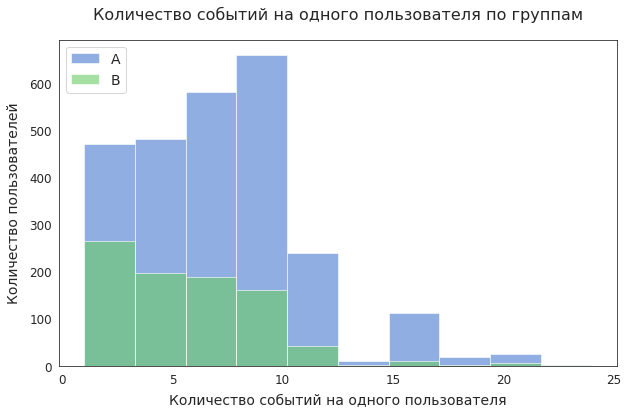

In [49]:
ax = df_a.groupby(['user_id']).agg({'event_name':'count'}).plot(kind='hist', alpha=0.6)
df_b.groupby(['user_id']).agg({'event_name':'count'}).plot(kind='hist', alpha=0.6, ax=ax)

plt.legend(labels=['A','B'])
plt.title('Количество событий на одного пользователя по группам')
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('Количество пользователей')
plt.show()

In [50]:
(df.groupby(['group', 'user_id'], as_index=False)['event_name'].agg(['count'])
 .groupby(['group'])['count'].agg(['min','max','mean'])
)

,min,max,mean
group,,,
A,1,24,6.903610
B,1,24,5.531357


3. Посмотрим, как распределено количество событий по дням:

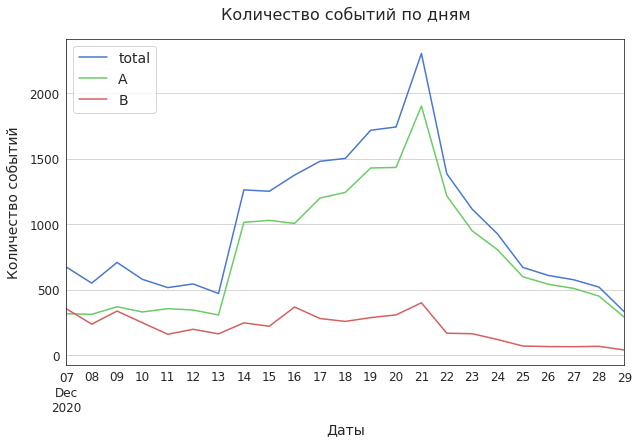

In [51]:
ax = df.groupby(['event_date']).agg({'user_id':'count'}).plot()
df_a.groupby(['event_date']).agg({'user_id':'count'}).plot(ax=ax)
df_b.groupby(['event_date']).agg({'user_id':'count'}).plot(ax=ax)

plt.legend(labels=['total','A','B'])
plt.grid()
plt.title('Количество событий по дням')
plt.xlabel('Даты')
plt.ylabel('Количество событий')
plt.show()

In [52]:
events_per_date = df.groupby(['event_date'], as_index=False).agg({'user_id':'count'})
events_max = events_per_date.max()
events_min = events_per_date.min()

print('Максимум событий произошло {} = {}'.format(events_max[0].strftime(format='%Y-%m-%d'), events_max[1]))
print('Минимум событий произошло {} = {}'.format(events_min[0].strftime(format='%Y-%m-%d'), events_min[1]))

Максимум событий произошло 2020-12-29 = 2304
Минимум событий произошло 2020-12-07 = 332


### Промежуточные выводы

На этом этапе выяснили:
- Из 6351 совершили хотя бы одно действие 3481 пользователей (54.8%);
- Характер распределения количества событий на одного пользователя различается: в группе A пик на 8-10, а в группе B – 1-3, но при этом более длинный хвост; среднее в группе А больше – 6.9 против 5.5 в группе B;
- Распределение количества событий по дням в группе B более ровное;
- Максимум событий произошло 2020-12-29 = 2304;
- Минимум событий произошло 2020-12-07 = 332.

 <div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-5'>Шаг 5. Оценка результатов A/B-тестирования</a>

1. Напишем функцию для проверки гипотез, которая будет:

   - Принимать на вход название события и значение критического уровня статистической значимости (alpha, по умолчанию будет равно 0.05);
   - Выводить анализируемое событие, нулевую и альтернативные гипотезы;
   - Рассчитывать и выводить долю пользователей, совершивших действие, в каждой группе;
   - Проводить z-тест и выводить его результаты.

In [53]:
def check_hyp(event, alpha=0.05):
    
    # пишем, какое событие анализируем   
    print(colored('Событие {} в группах A и B'.format(event), attrs=['bold']))
    
    # формулируем нулевую и альтернативную гипотезы
    print()
    print('H0: доли пользователей, совершивших событие {}, в группах A и B не различаются.'.format(event))
    print('H1: доли пользователей, совершивших событие {}, в группах A и B различаются.'.format(event))
    
    # считаем количество пользователей, совершивших событие, в каждой группе
    successesA = df_a.loc[df_a['event_name']==event, 'user_id'].nunique()
    successesB = df_b.loc[df_b['event_name']==event, 'user_id'].nunique()
    
    # вытаскиваем общее количество пользователей
    totalA = groups_cnt.loc[groups_cnt['group'] == 'A', 'user_id'].values[0]
    totalB = groups_cnt.loc[groups_cnt['group'] == 'B', 'user_id'].values[0]
    
    # находим доли
    propA = successesA / totalA
    propB = successesB / totalB
    
    # выводим доли + количество пользователей в группах
    print()
    print(f'{propA:.0%} от {totalA} пользователей с событием {event} в группе «A»')
    print(f'{propB:.0%} от {totalB} пользователей с событием {event} в группе «B»')
    
    
    ########## проверяем гипотезу ##########
      
    # пропорция успехов в группах
    pA = successesA / totalA
    pB = successesB / totalB

    # пропорция успехов в комбинированной группе
    p_combined = (successesA + successesB) / (totalA + totalB)

    # разница пропорций в группах
    difference = pA - pB
    
    # выводим, в какой группе конверсия лучше
    if difference > 0:
        print(colored('Конверсия в группе B хуже.', 'red'))
    else:
        print(colored('Конверсия в группе B лучше.', 'greed'))

    # статистика в стандартных отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/totalA + 1/totalB))

    # задаем стандартное нормальное распределение (среднее = 0, стандартное отклонение = 1)
    distr = st.norm(0, 1)
    
    # посчитаем, как далеко статистика уехала от нуля = какова вероятность получить такое отличие или больше
    # так как распределение статистики нормальное, вызовем метод cdf()
    # саму z-статистику возьмём по модулю методом abs(), чтобы получить правильный результат независимо от её знака
    # это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print()
    print(f'p-значение: {p_value:.4%}')

    # используем библиотеку termcolor
    if (p_value < alpha):
        print(colored('Отвергаем нулевую гипотезу: между долями есть значимая разница.', 'green'))
    else:
        print(colored('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.', 'red'))
    
    print()
    print()
    
    return

2. Так как мы будем проверять три гипотезы на одном наборе данных, используем поправку уровня статистической значимости методом Бонферрони:

In [54]:
alpha = 0.05
alpha_corr = alpha / 3

3. Проверим статистическую разницу долей по каждому событию:

In [55]:
for event in ['product_page', 'product_cart', 'purchase']:
    check_hyp(event, alpha=alpha_corr)

Событие product_page в группах A и B

H0: доли пользователей, совершивших событие product_page, в группах A и B не различаются.
H1: доли пользователей, совершивших событие product_page, в группах A и B различаются.

46% от 3634 пользователей с событием product_page в группе «A»
18% от 2717 пользователей с событием product_page в группе «B»
Конверсия в группе B хуже.

p-значение: 0.0000%
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Событие product_cart в группах A и B

H0: доли пользователей, совершивших событие product_cart, в группах A и B не различаются.
H1: доли пользователей, совершивших событие product_cart, в группах A и B различаются.

22% от 3634 пользователей с событием product_cart в группе «A»
9% от 2717 пользователей с событием product_cart в группе «B»
Конверсия в группе B хуже.

p-значение: 0.0000%
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Событие purchase в группах A и B

H0: доли пользователей, совершивших событие purchase, в

### Промежуточные выводы

По всем параметрам группа `B` хуже — конверсия в ней статистически значимо ниже.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='result'>Общие выводы</a>

Результаты A/B-теста следует признать неудачными: по всем параметрам группа B хуже — конверсия в ней статистически значимо ниже, чем в контрольной группе A.

При этом нужно заметить, что при проведении теста были особенности:
- 25% пользователей участвовали в двух тестах одновременно;
- Пользователи распределялись по группам неравномерно (относительное различие в количестве пользователей в группах = 25.2%);
- Во время теста проходила новогодняя акция, поэтому поведение пользователей могло быть нестандартным.

В целом, рекомендуем **НЕ внедрять** тестируемое изменение в продукт.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>